In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
import statsmodels.api as sm
import sklearn as sks
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB

## Getting the Training and Testing Datasets

In [2]:
#sitting dataset 8 row 54
folders = {
    'bending1': 7,
    'bending2': 6,
    'cycling': 15,
    'lying' : 15,
    'sitting': 15,
    'standing': 15,
    'walking': 15  
}
testing_paths = []
training_paths = []
ordered_paths = []
for activity, _max in folders.items():
    for i in range(1, _max + 1):
        ordered_paths.append((f'../data/{activity}/dataset{i}.csv', activity))
        if i <= 2:
            testing_paths.append(f'../data/{activity}/dataset{i}.csv')    
        elif i == 3 and activity not in ['bending1', 'bending2']:
            testing_paths.append(f'../data/{activity}/dataset{i}.csv')
        else:
            training_paths.append(f'../data/{activity}/dataset{i}.csv')
            
columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
testing_dfs = [pd.read_csv(path, skiprows = 4).iloc[:, 1:] for path in testing_paths]
training_dfs = []
for i, path in enumerate(training_paths):
    if path == f'../data/bending2/dataset4.csv':
        df = pd.read_csv(f'../data/bending2/dataset4.csv', skiprows = 5, delimiter = ' ', index_col = False, names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']).iloc[:, 1:]
    else:
        df = pd.read_csv(path, skiprows=4).iloc[:, 1:]
#         if i == 37:
#             print(df.describe())
    training_dfs.append(df)


print(f"Number of instances {len(testing_dfs) + len(training_dfs)}")
print(f"Number of testing instances {len(testing_dfs)}")
print(f"Number of training instances {len(training_dfs)}")

# for i, df in enumerate(training_dfs):
#     print(i, df.shape)

Number of instances 88
Number of testing instances 19
Number of training instances 69


# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

cols = ['Mean_1', 'Q1_1', 'Q3_1', 'Mean_2', 'Q1_2', 'Q3_2', 'Mean_6', 'Q1_6', 'Q3_6', 'Label']
column_nums = [1,2,6] # take col - 1 for proper indexing
rows = []
for df, path in zip(training_dfs, training_paths):
    label = path.split('/')[2]
    if 'bending' in label:
        label = 0
    else:
        label = 1
    row = []
    for val in column_nums:
        row.append(df[df.columns[val-1]].astype(float).mean())
        row.append(df[df.columns[val-1]].astype(float).quantile(0.25))
        row.append(df[df.columns[val-1]].astype(float).quantile(0.75))
    row.append(label)
    rows.append(row)
scatter_df = pd.DataFrame(rows, columns = cols)
sns.pairplot(scatter_df, vars = scatter_df.columns[:-1], hue="Label")
plt.show()

### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

cols = ['Mean_1_first', 'Mean_1_second', 'Q1_1_first', 'Q1_1_second', 'Q3_1_first', 'Q3_1_second', 'Mean_2_first', 'Mean_2_second', 'Q1_2_first', 'Q1_2_second', 'Q3_2_first', 'Q3_2_second', 'Mean_6_first', 'Mean_6_second', 'Q1_6_first', 'Q1_6_second', 'Q3_6_first', 'Q3_6_second', 'Label']
column_nums = [1,2,6] # take col - 1 for proper indexing
rows = []
for df, path in zip(training_dfs, training_paths):
    label = path.split('/')[2]
    half = len(df) // 2
    if 'bending' in label:
        label = 1
    else:
        label = 0
    row = []
    for val in column_nums:
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        row.append(current[:half].mean())
        row.append(current[half:].mean())
        row.append(np.percentile(current[:half], 25, method = 'midpoint'))
        row.append(np.percentile(current[half:], 25, method = 'midpoint'))
        row.append(np.percentile(current[:half], 75, method = 'midpoint'))
        row.append(np.percentile(current[half:], 75, method = 'midpoint'))
    row.append(float(label))
    rows.append(row)

scatter_df = pd.DataFrame(rows, columns = cols)
sns.pairplot(scatter_df, vars = scatter_df.columns[:-1], hue="Label")
plt.show()

### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

column_nums = [1,2,6] # take col - 1 for proper indexing
best_score = float('-inf') 
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        if 'bending' in label:
            label = 1
        else:
            label = 0
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
#             current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
            while start < len(df):
#                 row.append(current[start:start+size].mean())
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
#                 row.append(np.percentile(current[start:start+size], 25, method = 'midpoint'))
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
#                 row.append(np.percentile(current[start: start + size], 75, method = 'midpoint'))
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
        
    column_names.append('Label')
    logr_df = pd.DataFrame(rows, columns = column_names)
    logit = LogisticRegression()
    rfecv = RFECV(estimator=logit,cv=StratifiedKFold(5))
    model = rfecv.fit(logr_df.iloc[:,:-1], logr_df.iloc[:,-1].astype(int))
    if max(model.cv_results_['mean_test_score']) > best_score:
        best_score = max(model.cv_results_['mean_test_score'])
        best_model = model
        best_params = model.get_feature_names_out()
        best_l = l
        best_train_df = logr_df.copy()

print(f'Best l is {best_l}')
print(f'Best params are {best_params}')
print(max(best_model.cv_results_['mean_test_score']))

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

y_train_best = best_train_df.iloc[:,-1]
X_train_best = best_train_df[best_params].copy()
pred = best_model.predict(best_train_df.iloc[:,:-1])
cm=metrics.confusion_matrix(y_train_best,pred)
print(cm)
metrics.plot_roc_curve(best_model, best_train_df.iloc[:,:-1], best_train_df.iloc[:,-1])
log_reg = sm.Logit(y_train_best, X_train_best).fit(method='lbfgs')
print(log_reg.summary())

### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

rows = []
for df, path in zip(testing_dfs, testing_paths):
    size = math.ceil(len(df) / best_l)
    label = path.split('/')[2]
    if 'bending' in label:
        label = 1
    else:
        label = 0
    row = []
    column_names = []
    for val in column_nums:
        start = 0
        part = 1
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        while start < len(df):
#                 row.append(current[start:start+size].mean())
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
            column_names.append(f'Mean_{val}_{part}')
#                 row.append(np.percentile(current[start:start+size], 25, method = 'midpoint'))
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
            column_names.append(f'Q1_{val}_{part}')
#                 row.append(np.percentile(current[start: start + size], 75, method = 'midpoint'))
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
            column_names.append(f'Q3_{val}_{part}')
            start = start + size
            part += 1
    row.append(label)
    rows.append(row[:])

column_names.append('Label')
test_df = pd.DataFrame(rows, columns = column_names)
test_df.shape

X_test_df = test_df.iloc[:,:-1]
y_test_df = test_df.iloc[:, -1]
preds = best_model.predict(X_test_df)
score = best_model.score(X_test_df, y_test_df)
print(score)

### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

cm=metrics.confusion_matrix(y_test_df,preds)
print(cm)

In [3]:
column_nums = [1,2,6] # take col - 1 for proper indexing
cc_best_score = float('-inf')
oversample = SMOTE()
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        if 'bending' in label:
            label = 1
        else:
            label = 0
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
            while start < len(df):
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
        
    column_names.append('Label')
    logr_df = pd.DataFrame(rows, columns = column_names)
    logit = LogisticRegression()
    rfecv = RFECV(estimator=logit,cv=StratifiedKFold(5))
    X, y = oversample.fit_resample(logr_df.iloc[:,:-1], logr_df.iloc[:,-1])
    model = rfecv.fit(X,y)
    if max(model.cv_results_['mean_test_score']) > cc_best_score:
        cc_best_score = max(model.cv_results_['mean_test_score'])
        cc_best_model = model
        cc_best_params = model.get_feature_names_out()
        cc_best_l = l
        cc_best_train_df = X.copy()

print(f'Best l is {cc_best_l}')
print(f'Best params are {cc_best_params}')
print(max(cc_best_model.cv_results_['mean_test_score']))

Best l is 13
Best params are ['Q3_1_1' 'Q1_1_4' 'Q1_1_5' 'Q3_1_5' 'Q3_1_6' 'Q3_1_7' 'Q1_1_8' 'Q1_2_6'
 'Q3_2_6' 'Q1_6_1' 'Mean_6_9' 'Q3_6_9' 'Mean_6_10' 'Q3_6_10' 'Mean_6_12'
 'Q3_6_12' 'Mean_6_13' 'Q3_6_13']
0.975


In [4]:
rows = []
for df, path in zip(testing_dfs, testing_paths):
    size = math.ceil(len(df) / cc_best_l)
    label = path.split('/')[2]
    if 'bending' in label:
        label = 1
    else:
        label = 0
    row = []
    column_names = []
    for val in column_nums:
        start = 0
        part = 1
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        while start < len(df):
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
            column_names.append(f'Mean_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
            column_names.append(f'Q1_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
            column_names.append(f'Q3_{val}_{part}')
            start = start + size
            part += 1
    row.append(label)
    rows.append(row[:])

column_names.append('Label')
test_df = pd.DataFrame(rows, columns = column_names)
test_df.shape

X_test_df = test_df.iloc[:,:-1]
y_test_df = test_df.iloc[:, -1]
preds = cc_best_model.predict(X_test_df)
score = cc_best_model.score(X_test_df, y_test_df)
print(score)

0.8421052631578947


0.8421052631578947
[[14  1]
 [ 2  2]]


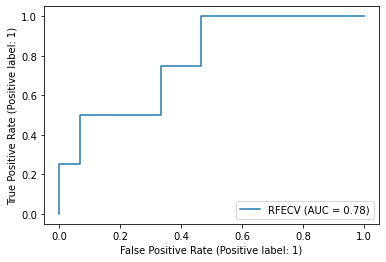

In [9]:
preds = cc_best_model.predict(X_test_df)
score = cc_best_model.score(X_test_df, y_test_df)
print(score)
cm=metrics.confusion_matrix(y_test_df,preds)
print(cm)
metrics.plot_roc_curve(cc_best_model,X_test_df, y_test_df)

## (b) Binary Classification Using L1-penalized logistic regression

### i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.9

column_nums = [1,2,6] # take col - 1 for proper indexing
l1_best_score = float('-inf') 
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        if 'bending' in label:
            label = 1
        else:
            label = 0
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
            while start < len(df):
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
        
    column_names.append('Label')
    logr_df = pd.DataFrame(rows, columns = column_names)
    logit = LogisticRegressionCV(solver='liblinear',penalty='l1', cv=5, random_state=0)
    model = logit.fit(logr_df.iloc[:,:-1], logr_df.iloc[:,-1].astype(int))
    score = model.score(logr_df.iloc[:,:-1], logr_df.iloc[:,-1].astype(int))
    if score > l1_best_score:
        l1_best_score = score
        l1_best_model = model
#         l1_best_params = model.get_feature_names_out()
        l1_best_c = model.C_
        l1_best_l = l
        l1_best_train_df = logr_df.copy()

print(f'Best l is {l1_best_l}')
print(f'Best Cs are {l1_best_c}')
print(l1_best_score)

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

l1 better

## (c) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.11

column_nums = [1,2,6] # take col - 1 for proper indexing
multi_best_score = float('-inf') 
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
            while start < len(df):
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
    
    column_names.append('Label')
    logr_df = pd.DataFrame(rows, columns = column_names)
    logit = LogisticRegressionCV(solver='saga',penalty='l1', cv=5, random_state=0)
    model = logit.fit(logr_df.iloc[:,:-1], logr_df.iloc[:,-1])
    score = model.score(logr_df.iloc[:,:-1], logr_df.iloc[:,-1])
    if score > multi_best_score:
        multi_best_score = score
        multi_best_model = model
        multi_best_c = model.C_
        multi_best_l = l
        multi_best_train_df = logr_df.copy()

print(f'Best l is {multi_best_l}')
print(f'Best Cs are {multi_best_c}')
print(multi_best_score)

#Test Data
rows = []
for df, path in zip(testing_dfs, testing_paths):
    size = math.ceil(len(df) / multi_best_l)
    label = path.split('/')[2]
    row = []
    column_names = []
    for val in column_nums:
        start = 0
        part = 1
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        while start < len(df):
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
            column_names.append(f'Mean_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
            column_names.append(f'Q1_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
            column_names.append(f'Q3_{val}_{part}')
            start = start + size
            part += 1
    row.append(label)
    rows.append(row[:])

column_names.append('Label')
multi_test_df = pd.DataFrame(rows, columns = column_names)
multi_test_df.shape

X_test_df_multi = multi_test_df.iloc[:,:-1]
y_test_df_multi = multi_test_df.iloc[:, -1]
preds = multi_best_model.predict(X_test_df_multi)
score = multi_best_model.score(X_test_df_multi, y_test_df_multi)
print(score)

confusion = metrics.confusion_matrix(y_test_df_multi, preds)
print('Confusion Matrix\n')
print(confusion)

# metrics.plot_roc_curve(multi_best_model, multi_best_train_df.iloc[:,:-1], multi_best_train_df.iloc[:,-1])


### ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [ ]:
column_nums = [1,2,6] # take col - 1 for proper indexing
naive_best_score = float('-inf') 
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
            while start < len(df):
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
    
    column_names.append('Label')
    nb_df = pd.DataFrame(rows, columns = column_names)
    nb = GaussianNB()
    model = nb.fit(nb_df.iloc[:,:-1], nb_df.iloc[:,-1])
    score = model.score(nb_df.iloc[:,:-1], nb_df.iloc[:,-1])
    if score > naive_best_score:
        naive_best_score = score
        naive_best_model = model
#         multi_best_c = model.C_
        naive_best_l = l
        naive_best_train_df = nb_df.copy()

print(f'Best l is {naive_best_l}')
# print(f'Best Cs are {multi_best_c}')
print(naive_best_score)

In [ ]:
#Test Data
rows = []
for df, path in zip(testing_dfs, testing_paths):
    size = math.ceil(len(df) / naive_best_l)
    label = path.split('/')[2]
    row = []
    column_names = []
    for val in column_nums:
        start = 0
        part = 1
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        while start < len(df):
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
            column_names.append(f'Mean_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
            column_names.append(f'Q1_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
            column_names.append(f'Q3_{val}_{part}')
            start = start + size
            part += 1
    row.append(label)
    rows.append(row[:])

column_names.append('Label')
naive_test_df = pd.DataFrame(rows, columns = column_names)
naive_test_df.shape

X_test_df_naive = naive_test_df.iloc[:,:-1]
y_test_df_naive = naive_test_df.iloc[:, -1]
preds = naive_best_model.predict(X_test_df_naive)
score = naive_best_model.score(X_test_df_naive, y_test_df_naive)
print(score)

In [ ]:
confusion = metrics.confusion_matrix(y_test_df_naive, preds)
print('Confusion Matrix\n')
print(confusion)

In [ ]:
column_nums = [1,2,6] # take col - 1 for proper indexing
naive_best_score = float('-inf') 
for l in range(1, 21):
    rows = []
    for df, path in zip(training_dfs, training_paths):
        size = math.ceil(len(df) / l)
        label = path.split('/')[2]
        row = []
        column_names = []
        for val in column_nums:
            start = 0
            part = 1
            while start < len(df):
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
                column_names.append(f'Mean_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
                column_names.append(f'Q1_{val}_{part}')
                row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
                column_names.append(f'Q3_{val}_{part}')
                start = start + size
                part += 1
        row.append(label)
        rows.append(row[:])
    
    column_names.append('Label')
    nb_df = pd.DataFrame(rows, columns = column_names)
    nb = MultinomialNB()
    model = nb.fit(nb_df.iloc[:,:-1], nb_df.iloc[:,-1])
    score = model.score(nb_df.iloc[:,:-1], nb_df.iloc[:,-1])
    if score > naive_best_score:
        naive_best_score = score
        naive_best_model = model
#         multi_best_c = model.C_
        naive_best_l = l
        naive_best_train_df = nb_df.copy()

print(f'Best l is {naive_best_l}')
# print(f'Best Cs are {multi_best_c}')
print(naive_best_score)

In [ ]:
#Test Data
rows = []
for df, path in zip(testing_dfs, testing_paths):
    size = math.ceil(len(df) / naive_best_l)
    label = path.split('/')[2]
    row = []
    column_names = []
    for val in column_nums:
        start = 0
        part = 1
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        while start < len(df):
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).mean())
            column_names.append(f'Mean_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.25))
            column_names.append(f'Q1_{val}_{part}')
            row.append(df[df.columns[val-1]].iloc[start:start+size].astype(float).quantile(0.75))
            column_names.append(f'Q3_{val}_{part}')
            start = start + size
            part += 1
    row.append(label)
    rows.append(row[:])

column_names.append('Label')
naive_test_df = pd.DataFrame(rows, columns = column_names)
naive_test_df.shape

X_test_df_naive = naive_test_df.iloc[:,:-1]
y_test_df_naive = naive_test_df.iloc[:, -1]
preds = naive_best_model.predict(X_test_df_naive)
score = naive_best_model.score(X_test_df_naive, y_test_df_naive)
print(score)

In [ ]:
confusion = metrics.confusion_matrix(y_test_df_naive, preds)
print('Confusion Matrix\n')
print(confusion)

### iii. Which method is better for multi-class classification in this problem?

# 3. ISLR, 4.8.3

# 4. ISLR 4.8.7